<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive

drive.mount('/content/drive/')

%cd drive/My \ Drive/Text_Summarization

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/My  Drive/Text_Summarization'
/content/drive/My  Drive/Text_Summarization


In [31]:
import json
import pandas as pd
import numpy as np


import re

# Load Data

In [32]:
with open("Data/Telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [33]:
dict_articles = json.loads(corpus.replace("\n",""))

In [34]:
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

In [35]:
df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [36]:
df_metadata = pd.read_excel("Data/Metadata_telehealth_article_key_2.25.xlsx",sheet_name="Tied_to_Notebook",index_col="Index")
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [37]:
#Ensure Both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

In [38]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [39]:
df_metadata.dtypes

Journal Title     object
Article Title     object
Date Published     int64
Authors           object
Abstract          object
Keywords          object
Citation          object
Content           object
dtype: object

# Clean Data
1.   Lowercase
2.   Remove Punctuation
3.   White Spaces



In [40]:
import string

In [41]:
def clean_text(text,lowercase=False):
    
    corpus =  text

    punc = string.punctuation.replace("-","")
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans(" "," ",punc)
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return " ".join(remove_extra_whitespaces)





In [42]:
df_metadata["Content_Length"] = df_metadata["Content"].apply(lambda text: len(text))
df_metadata["Abstract_Length"] = df_metadata["Abstract"].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata["Parsed_Keywords_Length"] = df_metadata["Parsed_Keywords"].apply(lambda text: len(text))


#Have an idea of reference amount per document
df_metadata["et_al_Count"] = df_metadata["Content"].apply(lambda text: len(list(re.finditer("et al",text))))


In [43]:
#emental health

#df_metadata["Content"].iloc[2][4633:5000]
#df_metadata["Clean_Content"].iloc[2][4633:5000]

## EDA

In [44]:
import matplotlib
import matplotlib.pyplot as plt

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



matplotlib.rcParams["figure.figsize"] = (20, 7)

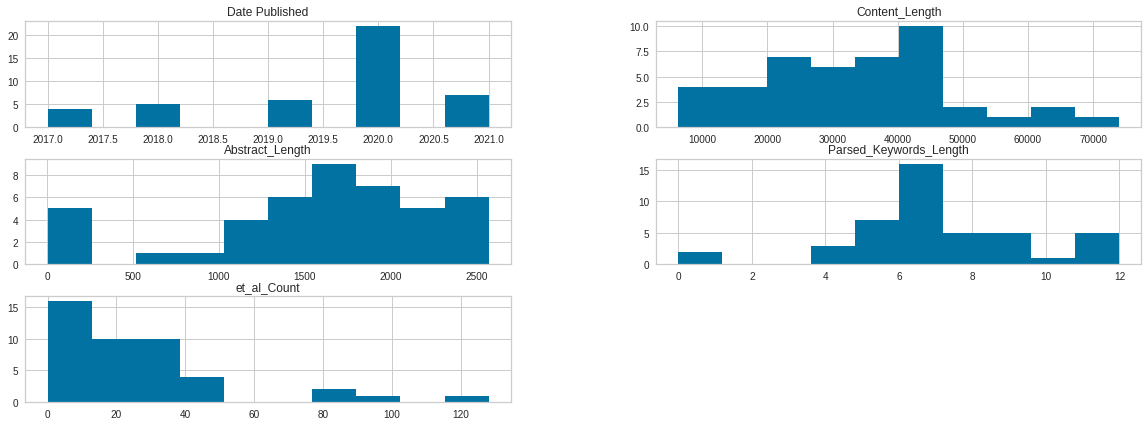

In [45]:
_ = df_metadata.hist()

In [46]:
# There are not strong linear correlations between the lengths or Date Published
df_metadata.corr()

,Date Published,Content_Length,Abstract_Length,Parsed_Keywords_Length,et_al_Count
Date Published,1.000000,0.209263,0.340628,-0.171761,0.206706
Content_Length,0.209263,1.000000,0.406046,0.253460,0.435310
Abstract_Length,0.340628,0.406046,1.000000,0.088227,0.335717
Parsed_Keywords_Length,-0.171761,0.253460,0.088227,1.000000,0.168458
et_al_Count,0.206706,0.435310,0.335717,0.168458,1.000000


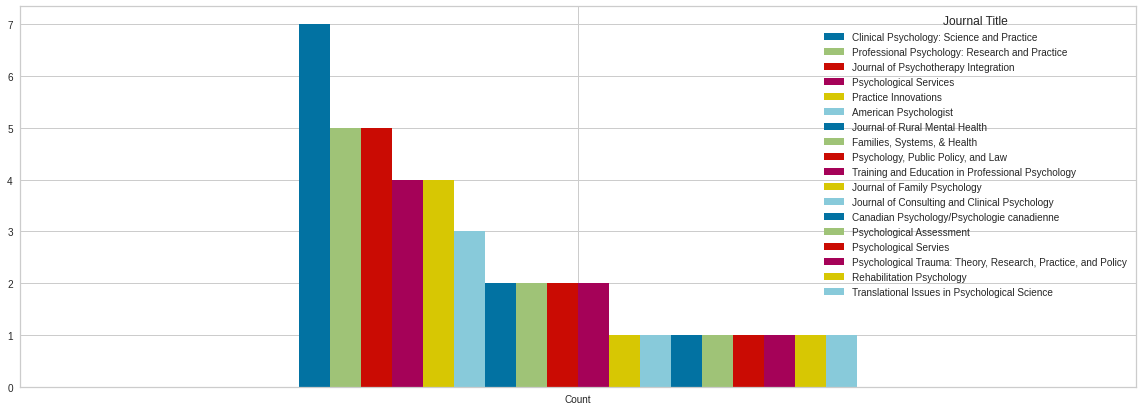

In [47]:
df_metadata[["Journal Title","Content"]].rename(columns={"Content":"Count"}).groupby("Journal Title").count().sort_values("Count",ascending=False).T.plot(kind="bar")

_ = plt.xticks(rotation=360)

# Cleaning

In [48]:
df_metadata["Clean_Content"] = df_metadata["Content"].apply(lambda text: clean_text(text,lowercase=False))
df_metadata["Clean_Content_length"] = df_metadata["Clean_Content"].apply(lambda text: len(text))

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,et_al_Count,Clean_Content,Clean_Content_length
Index,,,,,,,,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,50,Veterans face a variety of stressors related t...,36423
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,48,The impact of the COVID-19 pandemic on the chi...,72009
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,128,In November 2019 COVID-19—the infectious highl...,61640
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,21,Anxiety and depressive disorders are among the...,29392
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,14,In mid-March 2020 the authors—as well as the m...,41383


In [49]:
import spacy
corpus = df_metadata["Clean_Content"]

nlp = spacy.load("en_core_web_sm")
docs = list(nlp.pipe(corpus))

In [50]:
len(corpus)

44

## Lemmatization

In [51]:
lemmma_corpus = []

for index, doc in enumerate(docs):

        lemmma_corpus.append(" ".join([token.lemma_ for token in doc]))

In [52]:
len(lemmma_corpus)


44

## NER

In [53]:
for index, doc in enumerate(docs):
    if index < 5:
        print(f"Document {index}",[(ent.text,ent.label_) for ent in doc.ents][:10])
    else:
        break

Document 0 [('Institute of Medicine 2014', 'ORG'), ('Tanielian', 'NORP'), ('2008', 'DATE'), ('Substance Abuse and Mental Health Services Administration', 'WORK_OF_ART'), ('1', 'CARDINAL'), ('Tanielian', 'NORP'), ('2008', 'DATE'), ('Institute of Medicine 2014', 'ORG'), ('Lazar 2014', 'LAW'), ('Tanielian', 'NORP')]
Document 1 [('March April', 'DATE'), ('2020', 'CARDINAL'), ('Chenneville Schwartz-Mette', 'PERSON'), ('Luxton Nelson Maheu', 'PERSON'), ('2016', 'DATE'), ('beyondThe', 'GPE'), ('VC', 'ORG'), ('VC', 'ORG'), ('VC', 'ORG'), ('third', 'ORDINAL')]
Document 2 [('November 2019', 'DATE'), ('Wuhan', 'GPE'), ('China', 'GPE'), ('months', 'DATE'), ('April 2020', 'DATE'), ('the United States', 'GPE'), ('World Health Organization 2020', 'EVENT'), ('US', 'GPE'), ('The American Psychological Association APA', 'ORG'), ('two', 'CARDINAL')]
Document 3 [('the United States', 'GPE'), ('Liang et', 'PERSON'), ('Lopes Jaspal 2020', 'WORK_OF_ART'), ('Summers-Gabr', 'ORG'), ('Ruiz Gibson', 'PERSON'), (

# Text Mining - frequency counts of words, length of sentences, presence/absence of specific words

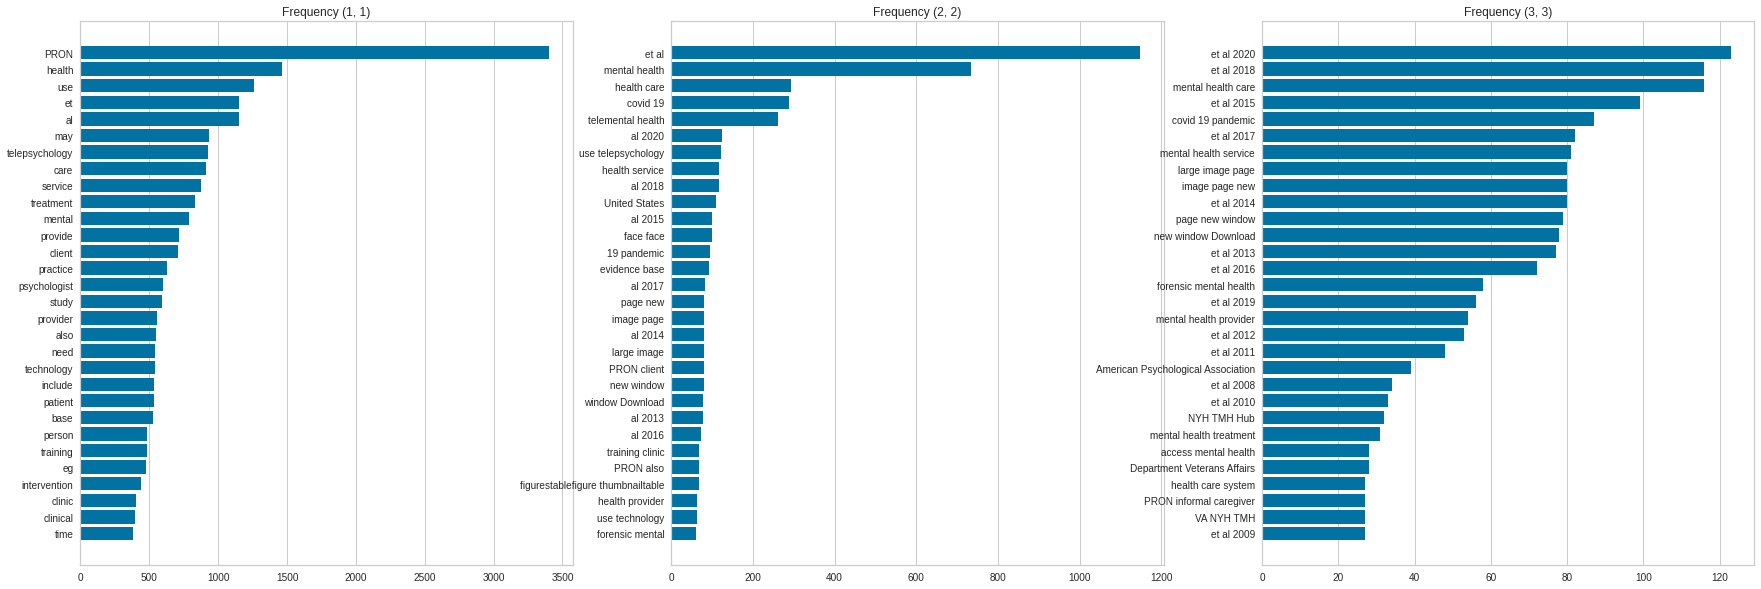

In [54]:
import nltk
from nltk.corpus import stopwords

#nltk.download("stopwords")

cust_stopwords = stopwords.words('english')

fig, ax = plt.subplots(1,3,figsize=(30,10))

figs = len(ax)

for i in range(figs):

    vectorizer = CountVectorizer(stop_words=cust_stopwords,ngram_range=(i+1,i+1),lowercase=False)
    docs = vectorizer.fit_transform(lemmma_corpus)
    features = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient="H",n=30,ax=ax[i])
    ax[i].set_title(f"Frequency {vectorizer.ngram_range}")
    _ = visualizer.fit(docs)

## Dispersion Plot

In [55]:
temp_doc = nlp("forensic e-mental")
# Lemma Removes e-mental
[(token.text,token.lemma_)for token in temp_doc]

[('forensic', 'forensic'), ('e', 'e'), ('-', '-'), ('mental', 'mental')]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


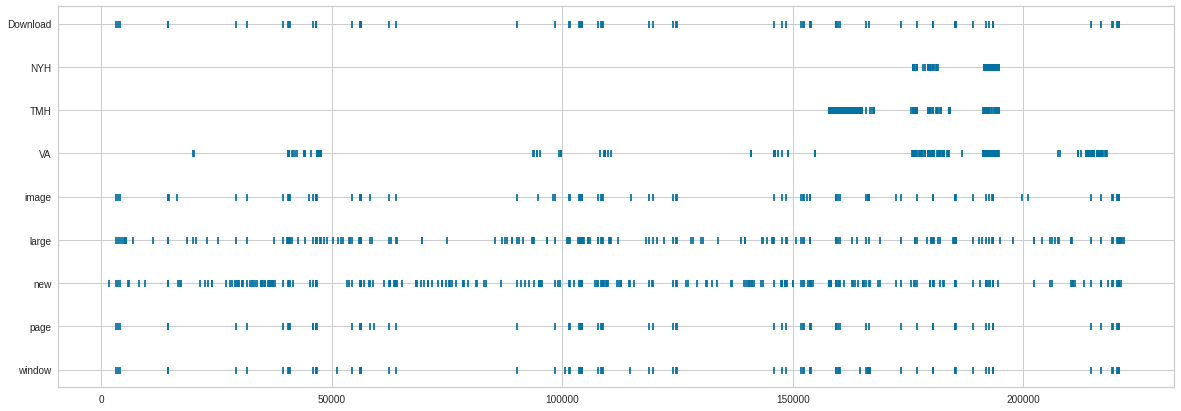

In [59]:
dispersion_text = [doc.split() for doc in lemmma_corpus]

# Choose words whose occurence in the text will be plotted:
not_found = ["1TABLESANDFIGUREstatefigure","AND FIGUREStatefigure"]
other_words = [token.split() for token in ["TMH","NYH TMH","VA","image page new","new window Download","page new window","large image page"]]
other_words_flattened = np.unique(np.concatenate(other_words).ravel().tolist())
target_words = other_words_flattened

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words,ignore_case=False)
_ = visualizer.fit(dispersion_text)

In [57]:
df_metadata["emental_Found"] = df_metadata["Content"].apply(lambda text: text.find("forensic emental health"))

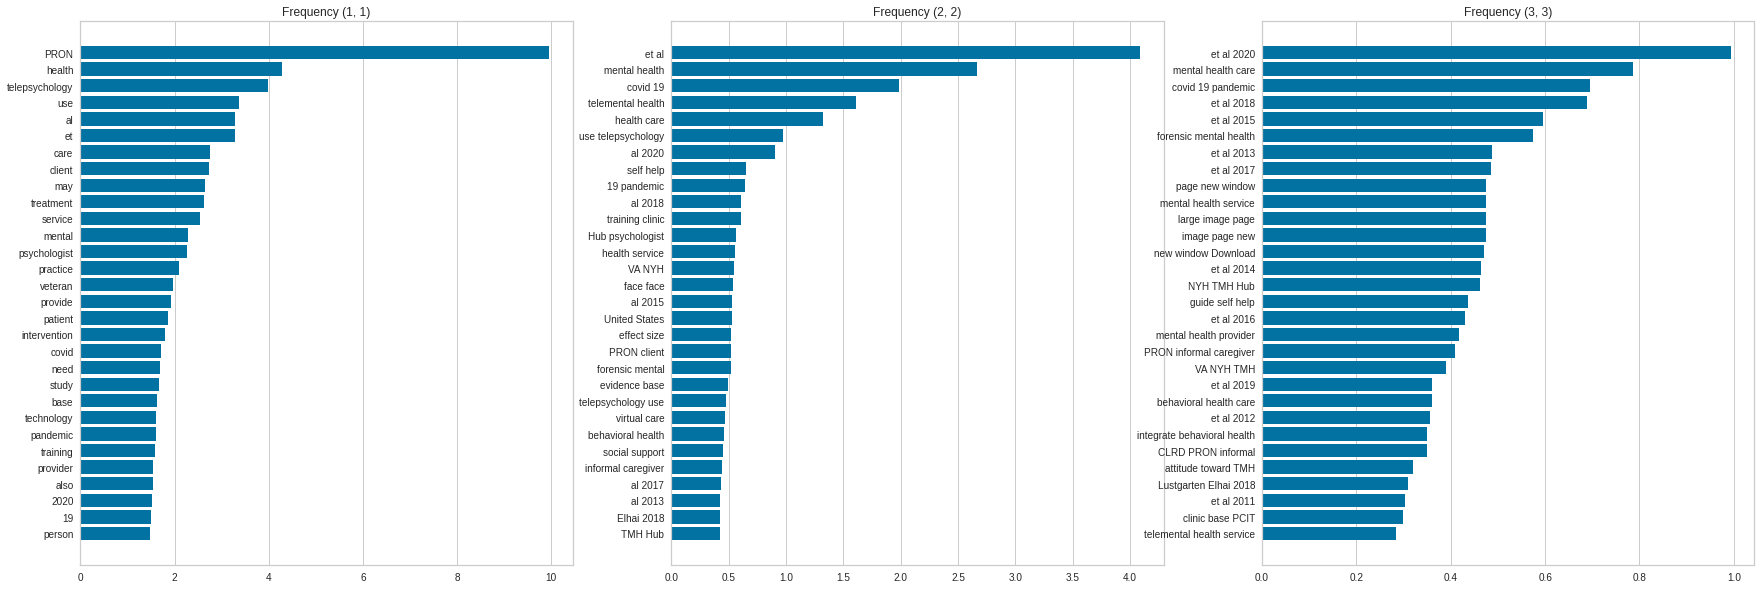

In [58]:
fig, ax = plt.subplots(1,3,figsize=(30,10))

figs = len(ax)

for i in range(figs):

    vectorizer = TfidfVectorizer(stop_words=cust_stopwords,ngram_range=(i+1,i+1),lowercase=False)
    docs       = vectorizer.fit_transform(lemmma_corpus)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient="H",n=30,ax=ax[i])
    ax[i].set_title(f"Frequency {vectorizer.ngram_range}")
    _ = visualizer.fit(docs)

## NLP - Natural Language Processing is one of the components of text mining NLP helps identify sentiments, find entities in the sentence and categories of blogs/articles/posts. 

## In text analytics, statistical and machine learning algorithms are primarily used to (1) classify, cluster,and summarize information, (2) to perform sentiment analysis, entity extraction and recognition, as well as similarity analysis and relation modeling

## Keyword Extraction and Text Summarization

## Text Similarity

## Sentiment